In [6]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

<Axes: >

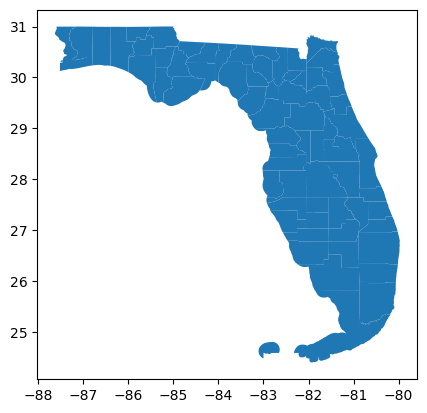

In [7]:
import geopandas as gpd
county_shp = gpd.read_file(r"F:\onedrive\OneDrive - University of Central Florida\Florida_shp\Florida_county.shp")
county_shp.plot()

### Univariate events generation

In [8]:
import os
import glob
import pandas as pd
import numpy as np

input_dir = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\SAIDI_merged_weather\*csv"
output_dir = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\categorized_data"
os.makedirs(output_dir, exist_ok=True)

uni_duration = []
for filepath in glob.glob(input_dir):
    ds = pd.read_csv(filepath, parse_dates=['Time'])
    
    # Total count of rows where 'class' equals 1
    total_count = ds[(ds['class'] == 1) & (ds['row_sum'] >= 1)].shape[0]
    
    # Define a function to dynamically determine columns to sum
    def get_sum_columns(ds, exclude_columns):
        return [col for col in ['prcp_cat', 'ws_cat', 'lis_cat', 'smois_cat', 'cape_cat', 'water_cat'] if col in ds.columns and col not in exclude_columns]

    # Calculate durations
    mean_prcp_duration = ((ds[(ds['prcp_cat'] == 1) & 
                              (ds['class'] == 1) & 
                              (ds[get_sum_columns(ds, ['prcp_cat'])].sum(axis=1) == 0)]['class'].count()) / total_count) * 100

    mean_ws_duration = ((ds[(ds['ws_cat'] == 1) & 
                            (ds['class'] == 1) & 
                            (ds[get_sum_columns(ds, ['ws_cat'])].sum(axis=1) == 0)]['class'].count()) / total_count) * 100

    mean_lis_duration = ((ds[(ds['lis_cat'] == 1) & 
                             (ds['class'] == 1) & 
                             (ds[get_sum_columns(ds, ['lis_cat'])].sum(axis=1) == 0)]['class'].count()) / total_count) * 100

    mean_smois_duration = ((ds[(ds['smois_cat'] == 1) & 
                               (ds['class'] == 1) & 
                               (ds[get_sum_columns(ds, ['smois_cat'])].sum(axis=1) == 0)]['class'].count()) / total_count) * 100

    mean_cape_duration = ((ds[(ds['cape_cat'] == 1) & 
                              (ds['class'] == 1) & 
                              (ds[get_sum_columns(ds, ['cape_cat'])].sum(axis=1) == 0)]['class'].count()) / total_count) * 100


    # Check if 'water_cat' exists in the DataFrame
    if 'water_cat' in ds.columns:
        mean_wl_duration = ((ds[(ds['water_cat'] == 1) & 
                                (ds['class'] == 1) & 
                                (ds[get_sum_columns(ds, ['water_cat'])].sum(axis=1) == 0)]['class'].count()) / total_count) * 100
    else:
        # Set mean_wl_duration to NaN if 'water_cat' is not available
        mean_wl_duration = np.nan

    # Save results for the current file
    base_name = os.path.basename(filepath)
    county_path = base_name.split('_')[0]
    uni_duration.append([
        county_path, mean_prcp_duration, mean_ws_duration, mean_lis_duration, 
        mean_smois_duration, mean_cape_duration, mean_wl_duration
    ])

# Convert results to a DataFrame
uni_df = pd.DataFrame(uni_duration, columns=['NAME', 'Prcp', 'WS', 'LIS', 'SMOIS', 'CAPE', 'WL'])

# Uncomment to save the DataFrame to CSV if needed
# output_path = os.path.join(output_dir, 'categorized_data_summary.csv')
# uni_df.to_csv(output_path, index=False)

# Print success message
# print("Data processing complete. Summary saved to output directory.")


In [9]:
uni_df_com = gpd.GeoDataFrame(pd.merge(county_shp, uni_df, on = 'NAME', how = 'inner'), crs = county_shp.crs)
uni_df_com.set_geometry('geometry', inplace = True)

#### County outlined

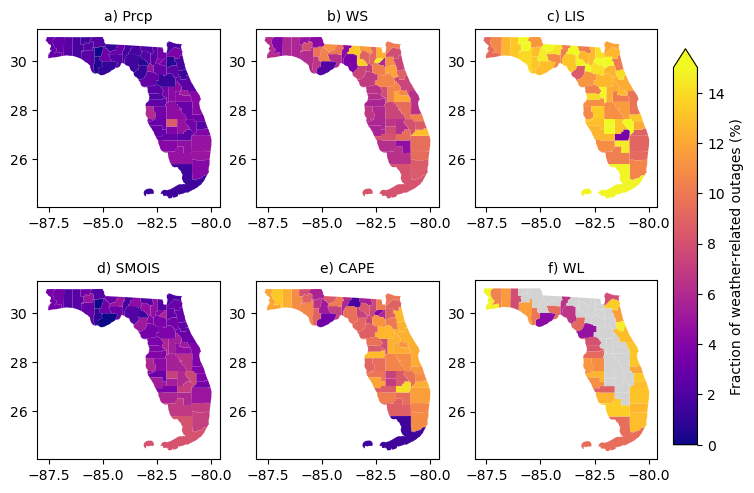

In [11]:

import matplotlib.patches as patches
from matplotlib.patches import Polygon

n_col = 3
n_row = 2
fig, axes = plt.subplots(n_row, n_col, figsize=(8, 6))
cax = fig.add_axes([0.92, 0.16, 0.03, 0.66])
vmin = 0
vmax = 15
axes = axes.flatten()
column_list = ['Prcp', 'WS', 'LIS', 'SMOIS', 'CAPE', 'WL']

for i, name in enumerate(column_list):
    # Construct the column name
    column_name = name

    if column_name == 'WL':  # Handle WL column separately for NaN values
        uni_df_com.plot(
            ax=axes[i],
            column=f'{column_name}',
            legend=True,
            cax=cax,
            cmap='plasma',
            vmin=vmin,
            vmax=vmax,
            missing_kwds={"color": "lightgray", "label": "No Data"}
        )
    else:
        # Plot other columns without specific handling for NaN
        uni_df_com.plot(
            ax=axes[i],
            column=f'{column_name}',
            legend=True,
            cax=cax,
            cmap='plasma',
            vmin=vmin,
            vmax=vmax
        )

    # Add subplot title with numbering
    axes[i].set_title(f'{chr(97 + i)}) {column_name}', fontsize=10)

# Hide any empty subplots
for j in range(len(column_list), len(axes)):
    axes[j].axis('off')

# Add colorbar with label
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax)),
    cax=cax,
    extend='max'
)
cbar.set_label('Fraction of weather-related outages (%)')


# Adjust layout to prevent overlapping and cropping
#plt.tight_layout(rect=[0, 0, 0.92, 0.93])

plt.show()


### Bivariate events

In [12]:
import os
import glob
import pandas as pd
import numpy as np

input_dir = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\SAIDI_merged_weather\*csv"
output_dir = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\categorized_data"
os.makedirs(output_dir, exist_ok=True)

compound_duration = []

for filepath in glob.glob(input_dir):
    ds = pd.read_csv(filepath, parse_dates=['Time'])
    
    # Calculate total count for the relevant rows
    total_count = ds[(ds['class'] == 1) & (ds['row_sum'] >= 1)].shape[0]
    
    # Handle cases where total_count is zero to avoid division by zero
    if total_count == 0:
        total_count = np.nan  # Assign NaN for rows where no valid data is present
    
    # Function to dynamically determine columns for summation
    def get_sum_columns(ds, exclude_columns):
        base_columns = ['prcp_cat', 'ws_cat', 'lis_cat', 'smois_cat', 'cape_cat']
        if 'water_cat' in ds.columns:
            base_columns.append('water_cat')
        return [col for col in base_columns if col in ds.columns and col not in exclude_columns]
    
    # Calculate percentages for each combination
    prcp_lis = ((ds[(ds['prcp_cat'] == 1) & (ds['lis_cat'] == 1) & (ds['class'] == 1) &
                    (ds[get_sum_columns(ds, ['prcp_cat', 'lis_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
        
    prcp_ws = ((ds[(ds['prcp_cat'] == 1) & (ds['ws_cat'] == 1) & (ds['class'] == 1) &
                   (ds[get_sum_columns(ds, ['prcp_cat', 'ws_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100

    prcp_smois = ((ds[(ds['prcp_cat'] == 1) & (ds['smois_cat'] == 1) &
                       (ds['class'] == 1) & 
                       (ds[get_sum_columns(ds, ['prcp_cat', 'smois_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
    
    ws_smois = ((ds[(ds['ws_cat'] == 1) & (ds['smois_cat'] == 1) &
                     (ds['class'] == 1) & 
                     (ds[get_sum_columns(ds, ['ws_cat', 'smois_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
    
    ws_lis = ((ds[(ds['ws_cat'] == 1) & (ds['lis_cat'] == 1) &
                   (ds['class'] == 1) & 
                   (ds[get_sum_columns(ds, ['ws_cat', 'lis_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
    
    lis_smois = ((ds[(ds['smois_cat'] == 1) & (ds['lis_cat'] == 1) &
                      (ds['class'] == 1) & 
                      (ds[get_sum_columns(ds, ['smois_cat', 'lis_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
   
    two_plus = ((ds[(ds['row_sum'] >= 2) & (ds['class'] == 1)]['Duration'].count()) / total_count) * 100
    
    if 'water_cat' in ds.columns:
        prcp_wl = ((ds[(ds['prcp_cat'] == 1) & (ds['water_cat'] == 1) &
                        (ds['class'] == 1) & 
                        (ds[get_sum_columns(ds, ['prcp_cat', 'water_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
       
        ws_wl = ((ds[(ds['ws_cat'] == 1) & (ds['water_cat'] == 1) &
                      (ds['class'] == 1) & 
                      (ds[get_sum_columns(ds, ['ws_cat', 'water_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
        
        lis_wl = ((ds[(ds['lis_cat'] == 1) & (ds['water_cat'] == 1) &
                       (ds['class'] == 1) & 
                       (ds[get_sum_columns(ds, ['lis_cat', 'water_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
        
        smois_wl = ((ds[(ds['smois_cat'] == 1) & (ds['water_cat'] == 1) &
                         (ds['class'] == 1) & 
                         (ds[get_sum_columns(ds, ['smois_cat', 'water_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
    
    else:
        # Set means to NaN if 'water_cat' is not available
        prcp_wl = np.nan
        ws_wl = np.nan
        lis_wl = np.nan
        smois_wl = np.nan
        
    # Save results for the current file
    base_name = os.path.basename(filepath)
    county_path = base_name.split('_')[0]
    compound_duration.append([county_path, prcp_lis, prcp_ws, prcp_smois, prcp_wl, ws_smois, ws_wl, ws_lis, lis_smois, lis_wl, smois_wl, two_plus])

# Convert results to a DataFrame
compound_df = pd.DataFrame(compound_duration, columns=['NAME', 'prcp_lis', 'prcp_ws', 'prcp_smois', 'prcp_wl', 'ws_smois', 'ws_wl', 'ws_lis', 'lis_smois', 'lis_wl', 'smois_wl', 'two_plus'])


In [18]:
compound_df_com = gpd.GeoDataFrame(pd.merge(county_shp, compound_df, on = 'NAME', how = 'inner'), crs = county_shp.crs)
compound_df_com.set_geometry('geometry', inplace = True)

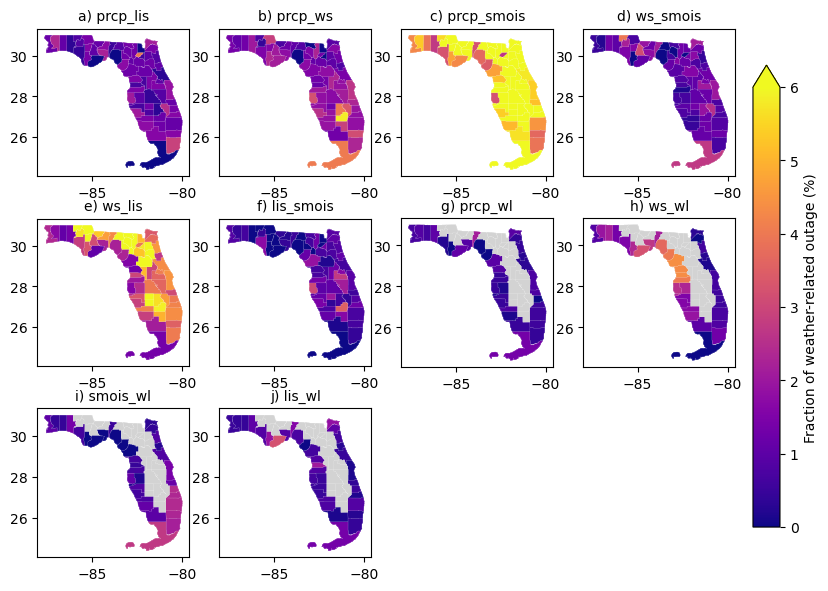

In [24]:
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
n_col = 4
n_row =3
fig, axes = plt.subplots(n_row, n_col, figsize = (9, 7))
cax = fig.add_axes([0.92, 0.16, 0.03, 0.66])
vmin = 0
vmax = 6
axes = axes.flatten()
column_list = ['prcp_lis', 'prcp_ws', 'prcp_smois', 'ws_smois', 'ws_lis', 'lis_smois', 'prcp_wl', 'ws_wl', 'smois_wl', 'lis_wl']
coastal_column = ['prcp_wl', 'ws_wl', 'smois_wl', 'lis_wl']
for i, name in enumerate(column_list):
    # Construct the column name with the '_SAIDI' suffix
    column_name = name
    for i, name in enumerate(column_list):
    # Construct the column name
        column_name = name
        
        if column_name in coastal_column:  # Handle WL column separately for NaN values
            # Plot with gray color for NaN values in the 'WL' column
            compound_df_com.plot(
                ax=axes[i],
                column=f'{column_name}',
                legend=True,
                cax=cax,
                cmap='plasma',
                vmin=vmin,
                vmax=vmax,
                missing_kwds={"color": "lightgray", "label": "No Data"},
                edgecolor = 'white',
                linewidth = 0.08
            )

        else:
            # Plot other columns without specific handling for NaN
        # Plot each column in a separate subplot with consistent color limits
            compound_df_com.plot(
                ax=axes[i], 
                column=f'{column_name}', 
                legend=True, 
                cax=cax, 
                cmap='plasma', 
                vmin=vmin, 
                vmax=vmax,
                edgecolor = 'white',
                linewidth = 0.08
            )
        axes[i].set_title(f'{chr(97 + i)}) {column_name}', fontsize=10)
# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Add colorbar with label
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cax , extend = 'max')
cbar.set_label('Fraction of weather-related outage (%)')


# Adjust layout to remove space after the title and prevent cropping
#plt.tight_layout(rect=[0, 0, 0.92, 0.95])